###### 03 Geometric Machine Learning for Shape Analysis

## C) Supervised Learning: Regression

$\color{#003660}{\text{Nina Miolane - Assistant Professor}}$ @ BioShape Lab @ UCSB ECE


<center><img src="figs/03_ratyz.png" width=350px alt="default"/></center>

# This Unit

- **Unit 1 (Geometry - Math!)**: Differential Geometry for Engineers
- **Unit 2 (Shapes)**: Computational Representations of Biomedical Shapes
- **Unit 3 (Machine Learning)**: **Geometric Machine Learning for Shape Analysis**
  - A) Mean and Covariance
  - B) Supervised Learning: Classification
  - **C) Supervised Learning: Regression**
    - Motivation: Regression on rats skulls
    - Tangent Machine Learning: Tangent linear regression
    - Geometric Machine Learning: Geodesic regression
  - D) Unsupervised Learning: Clustering
  - E) Unsupervised Learning: Dimension Reduction
- **Unit 4 (Deep Learning)**: Geometric Deep Learning for Shape Analysis

$\rightarrow$ We explain the machine learning algorithms and statistics used in these real-world scenarios.

<center><img src="figs/00_bioshape.jpg" width=350px alt="default"/></center>


# Overview of Machine Learning (ML)

Machine Learning is divided into two principal categories of algorithms: supervised and unsupervised learning algorithms. Both learn from data.

$\color{#EF5645}{\text{Definition}}$: **Supervised learning** refers to the task of learning a function that maps an input $x$ to an output $y$ based on example input-output pairs. We say that the model is:
- a classification if the outputs are categorical,
- a regression if the outputs are quantitative.

<center><img src="figs/03_sl2.png" width=900px alt="default"/></center>
<center>Supervised Learning</center>

# Regression



$\color{#EF5645}{\text{Given data}}$:
- $(X_1, ..., X_n)$:
  - inputs, e.g. ages of the rats, in days.
- $(y_1, ..., y_n)$: 
  - outputs, e.g. rat skull shapes.



<center><img src="figs/03_linear_regression.png" width=350px alt="default"/></center>
<center>Inputs: $X_1, ..., X_n \in \mathbb{R}$. Outputs $y_1, ..., y_n \in \mathbb{R}$.</center>

$\rightarrow \color{#EF5645}{\text{Goal}}$: Build $f$ that predicts the rat skull shape corresponding to a new time $X_\text{new}$.


## Method

1. Set-up
- $\color{#EF5645}{\text{Decide on the model:}}$ Function $f_\theta$, that outputs $\hat y = f_\theta(X)$: prediction for $y$.
  - $X$: input, e.g. time
  - $y$: true output (ground truth), e.g. true rat skull at this time
  - $\hat y = f_\theta(X)$: model output, e.g. model's predicted skull.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.


$\color{#047C91}{\text{Example}}$: 
- The model $f_\theta(X) = \theta_0 + \theta_1 X$ has parameters $\theta=(\theta_0, \theta_1)$.
- The loss function $L(y, \hat y) = d^2(y, \hat y)$ with $d$ is a notion of distance on shape spaces.
  - e.g. $L(y, \hat y)= |y - \hat y |^2 = |y - \theta_0 - \theta_1 X |^2$: least-squares.


2. $\color{#EF5645}{\text{Split dataset into train / test sets:}}$ 
   - Train $(X_1, y_1), ..., (X_{n_\text{train}}, y_{n_\text{train}})$: build the algorithm
   - Test $(X_{n_\text{train}+1}, y_{n_\text{train}+1}), ..., (X_n, y_n)$: assess its performances.
   
3. $\color{#EF5645}{\text{Train:}}$ Build the algorithm
   - Also called: "Fitting the model's parameters $\theta$."
   - Find $\theta^*$ such that the model predicts the train set best: 
   $$\theta^* = \text{argmin}_\theta \sum_{i=1}^{n_\text{train}} L(y_i, f_\theta(X_i))$$
   
4. $\color{#EF5645}{\text{Test:}}$ Assess its performances: 
   - Loss on test set: $\sum_{i=n_\text{train}+1}^{n} L(y_i, f_{\theta^*}(X_i))$

# Motivation: Regression of Rat Skulls Shapes

## Rat Skulls

We are interested in modeling the evolution of rat skulls shapes, in order to (later) evaluate if new rats have morphological issues at development.

<center><img src="figs/03_ratyz.png" width=400px alt="default"/></center>

<center>8 landmarks on a rat's skull.</center>

$\color{#EF5645}{\text{Question}}$: Given skulls of a rat at different time points, can we predict what is the shape of the skull of that rat at another time?

$\color{#EF5645}{\text{Our answer}}$: Regression on manifold:
- input: X = time in days: is a real number.
- output: y is a skull shape, represented in Kendall shape spaces, with 8 landmarks.


# Data

- Vilmann’s rat calvaria (skulls excluding the lower jaw) from X-ray images.
  - 8 landmarks in 2D for each shape.
- 18 individuals, out of which we extract the 1st one.
- 8 time points: at ages of 7, 14, 21, 30, 40, 60, 90, and 150 days.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["GEOMSTATS_BACKEND"] = "autograd"

In [3]:
import geomstats.datasets.utils as data_utils

data = np.load("03_rat_skulls.npy")
data_first = data[:8]
print(f"The data of the first rat has shape (n_times, n_landmarks, dim)={data_first.shape}.")

The data of the first rat has shape (n_times, n_landmarks, dim)=(8, 8, 2).


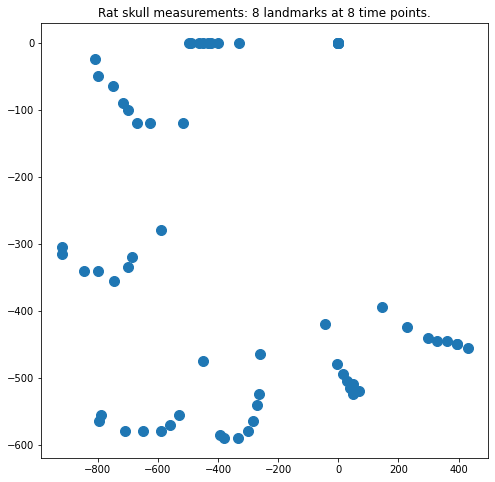

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = data_first.reshape(-1, 2)
plt_plot, = plt.plot(
    points[:, 0], points[:, 1], 'o', markersize=10)
ax.set_title("Rat skull measurements: 8 landmarks at 8 time points.");

## Regression Method 1: Tangent Machine Learning

### Recall: "Trick": Tangent Space at the Fréchet Mean

The Fréchet mean gives us a way of transforming our non-linear data into vectors!
1. Compute the Fréchet mean $\bar{x}$ of the data points
2. Consider the tangent space $T_\bar{x}M$of the manifold $M$ at $\bar{x}$
3. Compute the Logarithms of the data points at $\bar{x}$

$\rightarrow$ Get a dataset on a vector space, and apply classical machine learning on it.

$\color{#EF5645}{\text{In practice}}$: 
- Either use `FrechetMean` and `metric.log` methods.
- Or the function `ToTangentSpace` does both.

1. Set-up

- $\color{#EF5645}{\text{Decide on the model:}}$ Function $f_\theta$, that outputs $\hat y = f_\theta(X)$: prediction for $y$.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.

$\color{#047C91}{\text{Example}}$: 
- Use `ToTangentSpace` (do it manually here, with `FrechetMean`, `metric.log`)
- Use any regressor from `scikit-learn`, e.g. `LinearRegression`.
  - `LinearRegression` comes with its loss function.

In [5]:
from pre_shape_autodiff import PreShapeSpace, KendallShapeMetric
from geomstats.learning.frechet_mean import FrechetMean

from sklearn.linear_model import LinearRegression

preshape = PreShapeSpace(k_landmarks=8, m_ambient=2)
kendall_metric = KendallShapeMetric(k_landmarks=8, m_ambient=2)

mean = FrechetMean(metric=kendall_metric, point_type="matrix")
lr = LinearRegression()

2. $\color{#EF5645}{\text{Split dataset into train / test sets:}}$ 
   - Train $(X_1, y_1), ..., (X_{n_\text{train}}, y_{n_\text{train}})$: build the algorithm
   - Test $(X_{n_\text{train}+1}, y_{n_\text{train}+1}), ..., (X_n, y_n)$: assess its performances.

In [6]:
from sklearn.model_selection import train_test_split

X = np.linspace(0., 1., 8); X = np.atleast_2d(X).T
y = preshape.projection(data_first)
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"The dataset has {len(X)} skulls.")
print(f"The train set has {len(X_train)} skulls.")
print(f"The test set has {len(X_test)} skulls.")

The dataset has 8 skulls.
The train set has 6 skulls.
The test set has 2 skulls.


3. $\color{#EF5645}{\text{Train:}}$ Build the algorithm
   - Also called: "Fitting the model's parameters $\theta$."
   - Find $\theta^*$ such that the model predicts the train set best: 
   $$\theta^* = \text{argmin}_\theta \sum_{i=1}^{n_\text{train}} L(y_i, f_\theta(X_i))$$

In [7]:
from geomstats.learning.frechet_mean import FrechetMean

mean.fit(y_train)

tangent_y_train = kendall_metric.log(y_train, base_point=mean.estimate_)
tangent_y_test = kendall_metric.log(y_test, base_point=mean.estimate_)

In [8]:
lr.fit(X_train, tangent_y_train.reshape((6, -1)))

LinearRegression()

4. $\color{#EF5645}{\text{Test:}}$ Assess its performances: 
   - Loss on test set: $\sum_{i=n_\text{train}+1}^{n} L(y_i, f_{\theta^*}(X_i))$

In [9]:
print(tangent_y_test.shape)
score = lr.score(X_test, tangent_y_test.reshape((2, -1)))
print(f"We get a score of {score:.2f}.")

(2, 8, 2)
We get a score of -0.92.


Best possible score is 1, and the score can be negative because it can be arbitrarily bad.

Recall our question.

$\color{#EF5645}{\text{Question}}$: Given skulls of a rat through time, can we predict what is the shape of the skull of that rat at another time?

We can use the fitted model to make new predictions.

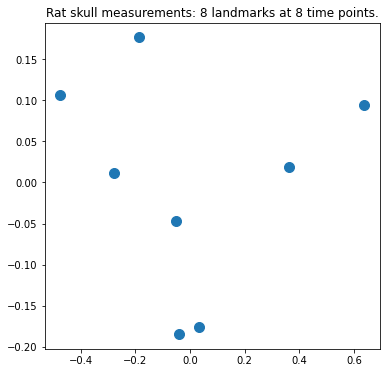

In [10]:
tangent_skull = lr.predict(np.array([[4.5]]))

fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot(111)
points = kendall_metric.exp(tangent_skull.reshape(-1, 2), base_point=mean.estimate_)
plt_plot, = plt.plot(points[:, 0], points[:, 1], 'o', markersize=10)
ax.set_title("Rat skull measurements: 8 landmarks at 8 time points.");

$\color{#EF5645}{\text{Remark}}$: We can use any regressor available in `scikit-learn`: not necessarily the `LinearRegression` regressor.

$\color{#047C91}{\text{Example}}$: Re-run with `RandomForestRegressor`.

In [11]:
from sklearn.ensemble import RandomForestRegressor
    
rfr = RandomForestRegressor()

rfr.fit(X_train, tangent_y_train.reshape((6, -1)))

score = rfr.score(X_test, tangent_y_test.reshape((2, -1)))

print(f"R^2 score: {score:.2f}.")

R^2 score: -1.90.


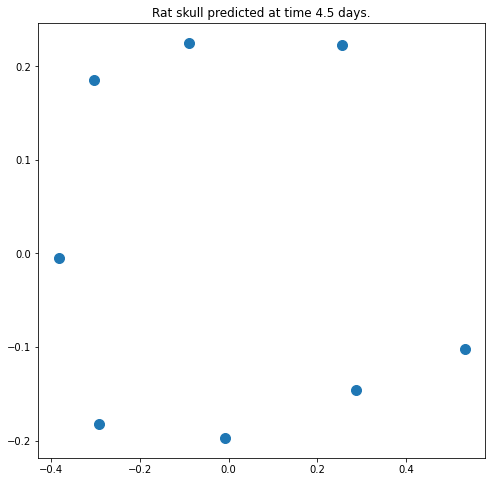

In [12]:
tangent_skull =  rfr.predict(np.array([[4.5]]))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = kendall_metric.exp(tangent_skull.reshape(-1, 2), base_point=mean.estimate_)
plt_plot, = plt.plot(
    points[:, 0], points[:, 1], 'o', markersize=10)
ax.set_title("Rat skull predicted at time 4.5 days.");

## Regression Method 2: Geodesic Regression

$\color{#EF5645}{\text{Previous subsection}}$: Regression Method 1:
- "Project" data on the tangent space at the FrechetMean: `ToTangentSpace`.
- Apply any traditional regression algorithm: 
  - e.g. `LinearRegression` or `RandomForestRegressor`.

$\color{#EF5645}{\text{This subsection}}$: Regression Method 2:
- Keep data on the manifold

## Method: Translate the Model

1. Set-up
- $\color{#EF5645}{\text{Decide on the model:}}$ Function $f_\theta$, that outputs $\hat y = f_\theta(X)$: prediction for $y$.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.


The linear regression model with $\theta_0, \theta_1 \in \mathbb{R}^m$:

$$f_\theta(X) = \theta_0 + \theta_1 X \in \mathbb{R}^m$$ 

Becomes: a geodesic regression model with $\theta_0 \in M$ and $\theta_1 \in T_{\theta_0}M$:

$$f_\theta(X) = \text{Exp}_{\theta_0}\left( \theta_1 X \right) \in M,$$
where Exp is the Riemannian exponential.

## Method: Translate the Loss Function

1. Set-up
- $\color{#EF5645}{\text{Decide on the model:}}$ Function $f_\theta$, that outputs $\hat y = f_\theta(X)$: prediction for $y$.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.


The loss function using the square Euclidean distance.
$$L(y, \hat y)= |y - \hat y |^2 = |y - \theta_0 - \theta_1 X |^2$$
now uses the square geodesic distance on $M$:
$$L(y, \hat y)= d_M(y, \hat y )^2 = d_M(y, \text{Exp}_{\theta_0}\left( \theta_1 X \right)  )^2.$$


<center><img src="figs/03_regressions.png" width=900px alt="default"/></center>


1. Set-up
- $\color{#EF5645}{\text{Decide on the model:}}$ Function $f_\theta$, that outputs $\hat y = f_\theta(X)$: prediction for $y$.
- $\color{#EF5645}{\text{Decide on a loss function:}}$ $L(y, \hat y)$ that evaluates if the model is right or wrong.
  - `GeodesicRegression` comes with its loss function.

In [13]:
from geomstats.learning.geodesic_regression import GeodesicRegression

gr = GeodesicRegression(
    space=preshape, metric=kendall_metric, 
    center_X=False, method="riemannian", initialization="warm_start")

# Warm-start
gr.intercept_ = y_train[0]  # theta0
gr.coef_ = kendall_metric.log(y_train[-1], y_train[0]) # theta1

Looking inside `GeodesicRegression`:
- https://github.com/geomstats/geomstats/blob/master/geomstats/learning/geodesic_regression.py

3. $\color{#EF5645}{\text{Train:}}$ Build the algorithm
   - Also called: "Fitting the model's parameters $\theta$."


In [14]:
gr.fit(np.squeeze(X_train), y_train)

GeodesicRegression(center_X=False, initialization='warm_start',
                   method='riemannian',
                   metric=<pre_shape_autodiff.KendallShapeMetric object at 0x1400a8130>,
                   space=<pre_shape_autodiff.PreShapeSpace object at 0x1400d6d30>)

Looking inside `GeodesicRegression`:
- https://github.com/geomstats/geomstats/blob/master/geomstats/learning/geodesic_regression.py

4. $\color{#EF5645}{\text{Test:}}$ Assess its performances: 
   - Loss on test set: $\sum_{i=n_\text{train}+1}^{n} L(y_i, f_{\theta^*}(X_i))$

In [15]:
print('R^2:', gr.score(np.squeeze(X_test), y_test))

R^2: 0.7472292798226752


In this case, computing with the data on the manifold directly gives much better results.

Looking inside `GeodesicRegression`:
- https://github.com/geomstats/geomstats/blob/master/geomstats/learning/geodesic_regression.py

Recall our question.

$\color{#EF5645}{\text{Question}}$: Given skulls of a rat through time, can we predict what is the shape of the skull of that rat at another time?

We can use the fitted model to make new predictions.

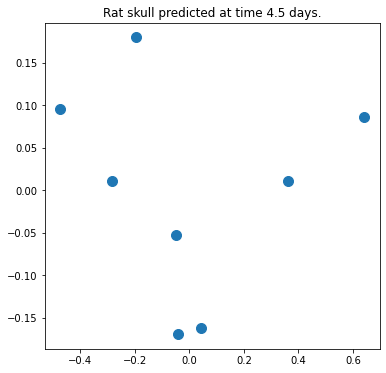

In [16]:
skull =  gr.predict(np.array([4.5]))
fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot(111)
points = skull.reshape(-1, 2); plt_plot, = plt.plot(points[:, 0], points[:, 1], 'o', markersize=10)
ax.set_title("Rat skull predicted at time 4.5 days.");

# This Unit

- **Unit 1 (Geometry - Math!)**: Differential Geometry for Engineers
- **Unit 2 (Shapes)**: Computational Representations of Biomedical Shapes
- **Unit 3 (Machine Learning)**: **Geometric Machine Learning for Shape Analysis**
  - A) Mean and Covariance
  - B) Supervised Learning: Classification
  - **C) Supervised Learning: Regression**
    - Motivation: Regression on aging rats skulls
    - Tangent Machine Learning: Tangent linear regression
    - Geometric Machine Learning: Geodesic regression
  - D) Unsupervised Learning: Clustering
  - E) Unsupervised Learning: Dimension Reduction
- **Unit 4 (Deep Learning)**: Geometric Deep Learning for Shape Analysis

$\rightarrow$ We explain the machine learning algorithms and statistics used in these real-world scenarios.

<center><img src="figs/00_bioshape.jpg" width=350px alt="default"/></center>
